Import stuff and initialize global parameters.

In [25]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_as_stacked

IMAGE_SIZE = (64, 64, 3)

# Convolutional network
Reading data as bundles and creating initial model.

In [26]:
images, labels = extract_training_data_as_stacked("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)

In [27]:
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1741, 3)

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='linear'))

model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 92259     
Total params: 95,747
Trainable params: 95,747
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1671 samples, validate on 70 samples
Epoch 1/10
1671/1671 [==============================] - 8s - loss: 4.7213 - val_loss: 0.4295
Epoch 2/10
1671/1671 [==============================] - 9s - loss: 0.1984 - val_loss: 0.2533
Epoch 3/10
1671/1671 [==============================] - 9s - loss: 0.1039 - val_loss: 0.2708
Epoch 4/10
1671/1671 [==============================] - 9s - loss: 0.0870 - val_loss: 0.2766
Epoch 5/10
1671/1671 [==============================] - 9s - loss: 0.0765 - val_loss: 0.2846
Epoch 6/10
1671/1671 [==============================] - 8s - loss: 0.0679 - val_loss: 0.2837
Epoch 7/10
1671/1671 [==============================] - 8s - loss: 0.0609 - val_loss: 0.3014
Epoch 8/10
1671/1671 [==============================] - 8s - loss: 0.0538 - val_loss: 0.3077
Epoch 9/10
1671/1671 [==============================] - 8s - loss: 0.0467 - val_loss: 0.3115
Epoch 10/10
1671/1671 [==============================] - 9s - loss: 0.0410 - val_loss: 0.3241


In [15]:
test_images, _ = extract_training_data_as_stacked("Data/20171029-201639.h264.avi", "Data/20171029-201639.h264.csv", IMAGE_SIZE)

prediction = model.predict(test_images)

### Convolutional network results

In [16]:
prediction

array([[ 0.1407572 ,  0.16268922,  0.9218393 ],
       [ 0.14913657,  0.18376924,  0.91827464],
       [ 0.1533201 ,  0.20075783,  0.93527007],
       ..., 
       [-0.01009087, -0.00982734,  0.98253912],
       [ 0.08406697, -0.0448154 ,  0.97497928],
       [-0.18870719,  0.05396052,  0.74136144]], dtype=float32)

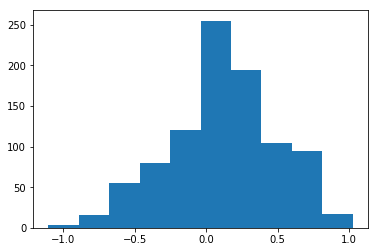

In [21]:
plt.hist(prediction[:, 0])
plt.show()

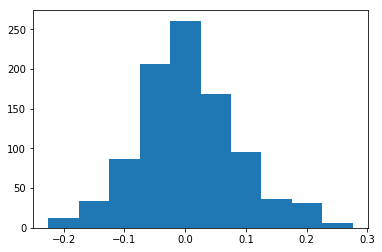

In [22]:
plt.hist(prediction[:, 1])
plt.show()

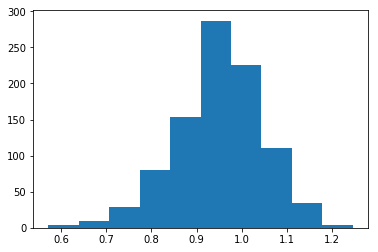

In [23]:
plt.hist(prediction[:, 2])
plt.show()